## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the datasets

In [2]:
train = pd.read_parquet("..\data\\train.parquet")
test = pd.read_parquet("..\data\\final_test.parquet")

# We drop bike count, as it can't b used for training
train.drop(columns=["bike_count"], inplace=True)

In [3]:
X = train.drop(columns=["log_bike_count"])
y = train["log_bike_count"]

## Prediction function formatter

The following function is used to format the prediction to match what is expected for a kaggle submission.

In [4]:
def kaggle_prediction(model, file_path, test_set=test):
    """
    Return a .csv file for kaggle submission (predictions of the test dataset)
    Parameters:
        - model : a fitted sklearn model object
        - test_set : the dataset to predict log_bike_count on 
    Output:
        - file.csv : a .csv file to submit to kaggle 
    """

    y_pred = model.predict(test_set)
    y_pred_df = pd.DataFrame(y_pred, columns=["log_bike_count"])
    y_pred_df.index.name = "Id"

    pd.to_csv(file_path)

    return None

## Pipeline creator

This section is to standardize the fitting of new models to streamline the process.

In [5]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   date                       496827 non-null  datetime64[us]
 5   counter_installation_date  496827 non-null  datetime64[us]
 6   coordinates                496827 non-null  category      
 7   counter_technical_id       496827 non-null  category      
 8   latitude                   496827 non-null  float64       
 9   longitude                  496827 non-null  float64       
 10  log_bike_count             496827 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(3), int64(

We will drop the `coordinates` column, as it is redundant with `latitude` and `longitude`. We will also drop `counter_id` and `site_id`, as they are redundant with `counter_name` and `site_name` respectively. To integrate this in a pipeline, we wrap it in a `FunctionTransformer`:

In [7]:
columns_to_drop = ["counter_id", "site_id", "coordinates"]

def drop_columns(X, columns_to_drop=columns_to_drop):
    return X.drop(columns=columns_to_drop)

# column_dropper = FunctionTransformer(lambda X: drop_columns(X, columns_to_drop=columns_to_drop), validate=False)
column_dropper = FunctionTransformer(drop_columns, validate=False)

In [8]:
def encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the "date" columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

date_encoder = FunctionTransformer(encode_dates, validate=False)
date_cols = encode_dates(X[["date"]]).columns.tolist()

In [9]:
categorical_columns = drop_columns(X).select_dtypes(include="category").columns
numerical_columns = drop_columns(X).select_dtypes(include="float").columns

### Compute score

We will compare models using the RMSE (Root Mean Squared Error). We define a function to wrap every step nicely:

In [10]:
def compute_rmse(estimator, X=X, y=y, cv=5):
    neg_rmse_list = cross_val_score(estimator, X, y, scoring="neg_root_mean_squared_error", cv=cv)
    avg_rmse = np.average(-neg_rmse_list)

    return avg_rmse

## Models

### Dummy model

We start with fitting a dummy classifier predicting the mean to get a baseline:

In [11]:
from sklearn.dummy import DummyRegressor

dummy_avg = DummyRegressor(strategy="mean")
dummy_avg.fit(X, y)

compute_rmse(dummy_avg)

np.float64(1.6628104074529002)

We will use this RMSE value of $1.66$ as a baseline to improve on.

### Linear Regression models

We will fit a basic linear regression model, keeping all features except the redundant ones (i.e. `counter_id`, `site_id` and `coordinates`).

We encode the categorical data with a `OneHotEncoder`.

In [21]:
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    [
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

compute_rmse(pipeline)

np.float64(1.6504729892276528)

The basic linear regressor is only very slightly better than the dummy classifier that predicts the average.

Let's visualize what it predicts:

In [13]:
basic_linear_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(basic_linear_regressor.predict(X[vis_mask])) - 1

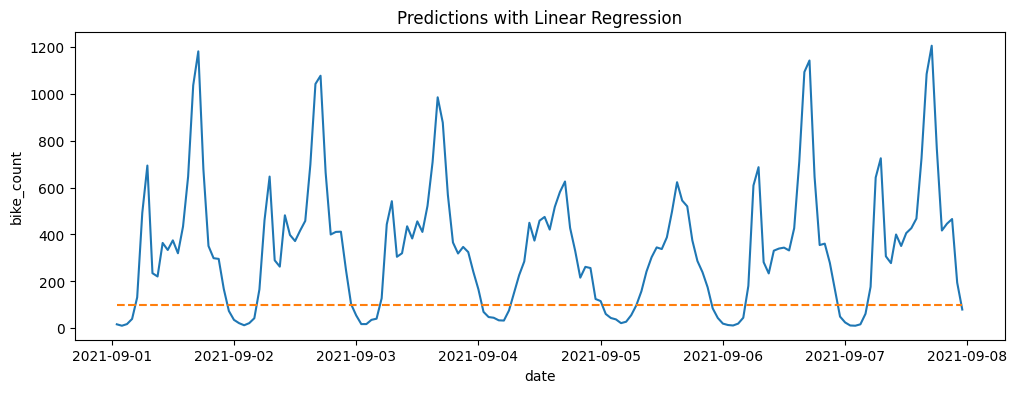

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Linear Regression")
ax.set_ylabel("bike_count")

plt.show()

Let's encode the dates:

In [15]:
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

compute_rmse(pipeline)

np.float64(1.0235175441378155)

Encoding the dates with `OneHotEncoder` significantly improves the model. However, we can try another encoding, as using `OneHotEncoder` loses the natural order existing between dates.

In [16]:
advanced_linear_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(advanced_linear_regressor.predict(X[vis_mask])) - 1

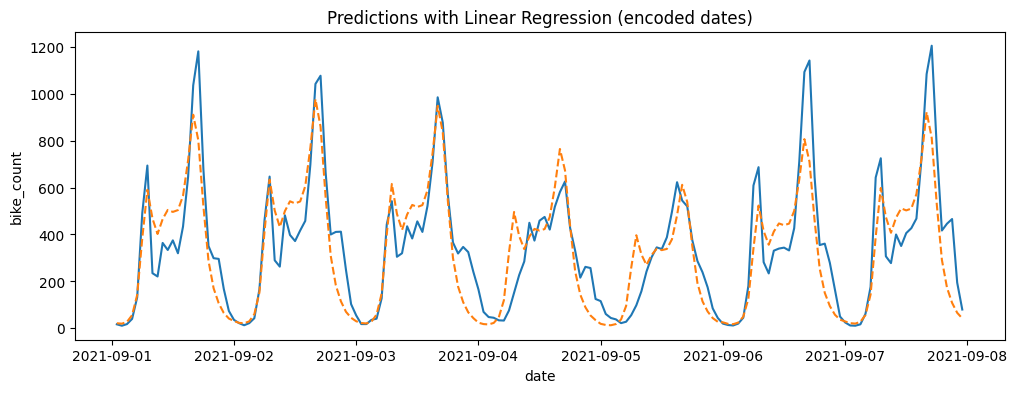

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Linear Regression (encoded dates)")
ax.set_ylabel("bike_count")

plt.show()

#### Ridge regression

In [24]:
from sklearn.linear_model import Ridge


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", Ridge())
    ]
)

compute_rmse(pipeline)

np.float64(1.0235161053146893)

No significant change with a Ridge regression.

In [26]:
ridge_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(ridge_regressor.predict(X[vis_mask])) - 1

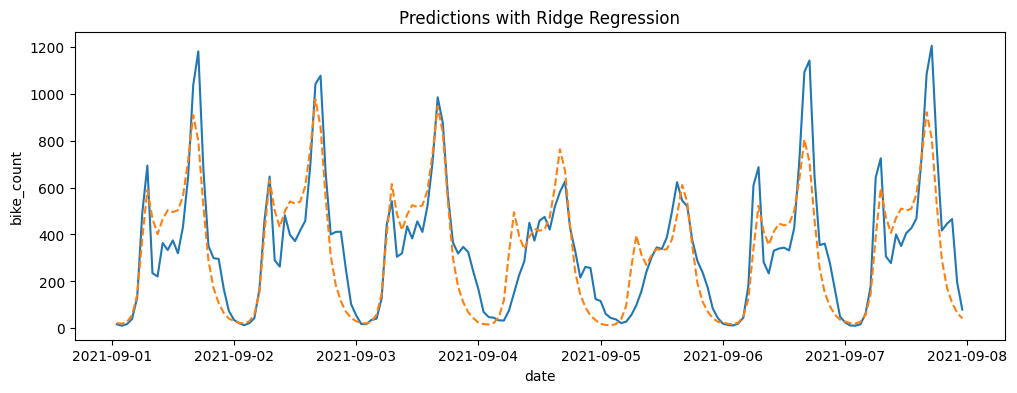

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge Regression")
ax.set_ylabel("bike_count")

plt.show()